In [1]:
# 导入需要的包
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 在输入矩阵的边缘使用零值进行填充，这样我们就可以对输入图像矩阵的边缘进行滤波。
def zero_pad(x, pad):
    X_pad = np.pad(x,((0,0),(pad,pad),(pad,pad),(0,0)), 'constant', constant_values=(0,0))
    return X_pad

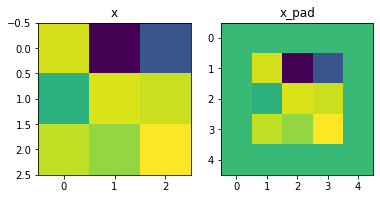

In [3]:
x = np.random.randn(4,3,3,2)
x_pad = zero_pad(x, 1)
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])


## conv layer forward

In [4]:
# 实现 单步卷积
# 与滤波器对应相乘
def conv_single_step(a_slice_prev, W, b):
    a_slice = np.multiply(a_slice_prev, W)
    a_slice = np.sum(a_slice)
    return a_slice + b

In [5]:
# 实现卷积操作
def conv_farward(A_prev, W, b, hyparameters):
    '''
    A_prev: 前一层 output    (m, n_H_prev, n_W_prev, n_C_prev)
    W: 权重  (f, f, n_C_prev, n_C)
    b: 偏置单元 (1, 1, 1, n_C)
    hyparameters: python dict    包含  stride 和 pad
    '''
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    f, f, n_C_prev, n_C = W.shape
    stride = hyparameters['stride']
    pad = hyparameters['pad']
    
    n_H = int((n_H_prev + 2 * pad - f) / stride) + 1
    n_W = int((n_W_prev + 2 * pad - f) / stride) + 1
    
    # 初始化
    Z = np.zeros((m, n_H, n_W, n_C))
    # 进行 0 填充
    A_prev_pad = zero_pad(A_prev, pad)
    # start conv operation
    for  i in range(m):
        a_prev_pad = A_prev[i]
        for  h in range(n_H_):
            for w in range(n_W):
                for c in range(n_C):
                    start_h = h * stride
                    start_w = w * stride
                    end_h = start_h + f
                    end_w = start_w + f
                    a_slice_prev = a_prev_pad[start_h:end_h, start_w:end_w, :]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W, b)
    # 确认卷积后尺寸
    assert(Z.shape == (m, n_H, n_W, n_C))
    cache = (A_prev, W, b, hparameters)
    return Z, cache 

## Pool layer forward


In [6]:
def pool_farward(A_prev, hyparameters, mode = 'max'):
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    
    f = hyparameters['f']
    stride = hyparameters['stride']
    
    n_H = int((n_H_prev - f) / stride) + 1
    n_W = int((n_W_prev - f) / stride) + 1
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C_prev))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    start_h = h * stride
                    start_w = w * stride
                    end_h = start_h + f
                    end_w = start_w + f
                    a_slice_prev = A_prev[i, start_h:end_h, start_w:end_w, c]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[i, h, w, c] = np.average(a_slice_prev)
    cache = (A_prev, hyparameters)
    
    assert(A.shape == (m, n_H, n_W, n_C_prev))
    return A, chche
                

## conv layer back

In [7]:
def conv_backward(dZ, cache):
    """
    dZ: Z代价的梯度   (m, n_H, n_W, n_C)
    cache: (A_prev, W, b, hparameters)  
    """
    (A_prev, W, b, hparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters['stride']
    pad = hparameters['pad']
    (m, n_H, n_W, n_C) = dZ.shape
    
    # 初始化dA dW db
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1,1,1,n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)

    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    start_h = h * stride
                    start_w = w * stride
                    end_h = start_h + f
                    end_w = start_w + f
                    a_slice_prev = a_prev_pad[start_h:end_h, start_w:end_h, :]
                    da_prev_pad[start_h:end_h,start_w:end_w,:] += W[:,:,:,c] + dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice_prev * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
        dA_prev[i, :, :, :] = dA_prev_pad[i, pad:-pad, pad:-pad, :]
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    return dA_prev, dW, db

## max pool back 

In [8]:
def create_mask_from_window(x):
    mask = (x == np.max(x))
    return mask

## average pool back

In [9]:
 def distribute_value(dz, shape):
    (n_H, n_W) = shape
    average = dz / (n_H * n_W)
    a = np.ones(shape) * average
    return a

## pool back

In [10]:
 def pool_backward(dA, cache, mode = "max"):
    (A_prev, hparameters) = cache
    stride = hparameters['stride']
    f = hparameters['f']
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape

    dA_prev = np.zeros_like(A_prev)
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    start_h = h * stride
                    end_h = start_h + f
                    start_w = w * stride
                    end_w = start_w + f
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start: vert_end, horiz_start:horiz_end, c] += mask * dA[i, vert_start, horiz_start, c]
                    elif mode == "average":
                        da = dA[i, vert_start, horiz_start, c]
                        shape = (f, f)
                        dA_prev[i, vert_start: vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
    assert(dA_prev.shape == A_prev.shape)
    return dA_prev

